# Data Science Bowl 2018

Find the nuclei in divergent images to advance medical discovery.

Create a computer model that can identify a range of nuclei across varied conditions. By observing patterns, asking questions, and building a model, participants will have a chance to push state-of-the-art technology farther.

In [18]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.metrics import error_rate
import numpy as np  
bs = 64

In [19]:
path = Path('/notebooks/storage/data/data-science-bowl-2018/')
path_train = path/'stage1_train'

In [20]:
codes = np.loadtxt( path/"stage1_train_labels.csv", delimiter=",", skiprows=1, dtype=str );

In [21]:
fnames = (sorted(path_train.glob('*/images/*.png')))
print(fnames[:3])

[PosixPath('/notebooks/storage/data/data-science-bowl-2018/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png'), PosixPath('/notebooks/storage/data/data-science-bowl-2018/stage1_train/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1/images/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1.png'), PosixPath('/notebooks/storage/data/data-science-bowl-2018/stage1_train/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e/images/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e.png')]


In [22]:
masks = (sorted(path_train.glob('*/masks/*.png')))
print(masks[:3])

[PosixPath('/notebooks/storage/data/data-science-bowl-2018/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png'), PosixPath('/notebooks/storage/data/data-science-bowl-2018/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/0e548d0af63ab451616f082eb56bde13eb71f73dfda92a03fbe88ad42ebb4881.png'), PosixPath('/notebooks/storage/data/data-science-bowl-2018/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/0ea1f9e30124e4aef1407af239ff42fd6f5753c09b4c5cac5d08023c328d7f05.png')]


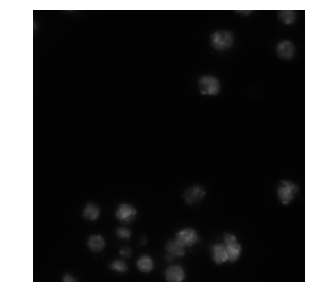

In [23]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [24]:
def get_y_fn(o):
    stem = (o.parts if isinstance(o, Path) else o.split(os.path.sep))[-3]
    return (path_train/stem/'images'/f'{stem}{o.suffix}')

ImageSegment (1, 256, 256)


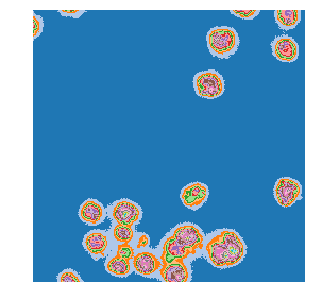

In [25]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)
get_y_fn(img_f)
print(mask)

In [26]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([256, 256]), tensor([[[5, 5, 5,  ..., 4, 3, 3],
          [6, 5, 5,  ..., 4, 4, 3],
          [6, 5, 5,  ..., 5, 4, 3],
          ...,
          [3, 3, 3,  ..., 2, 2, 3],
          [3, 3, 3,  ..., 2, 2, 2],
          [3, 2, 3,  ..., 2, 2, 2]]]))

In [27]:
size = src_size//2

bs = 4

In [28]:
src = (SegmentationItemList.from_folder(path_train)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes)
       )

## Stage 1 - Low Resolution

In [29]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

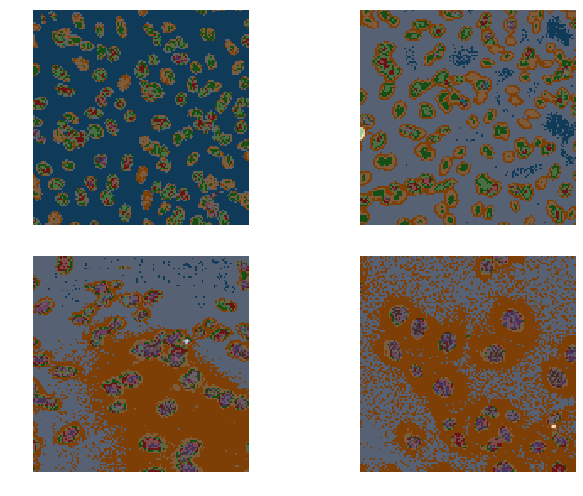

In [30]:
data.show_batch(2, figsize=(10,7))

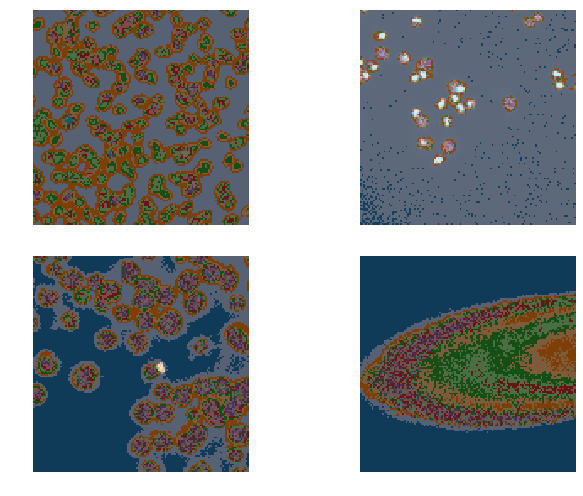

In [31]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [32]:
metrics=accuracy
wd=1e-2

In [33]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [35]:
lr=1e-3
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-1-small')

## Stage 2 - High Resolution

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
learn.data = data

In [ ]:
data.show_batch(2, figsize=(10,7))

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(12, max_lr=slice(1e-5,1e-2))

In [ ]:
learn.save('stage-2-big')